# Финальный проект по курсу DS Pro 2.0


Проект является реальной задачей поставленной департаментом здравоохранения города Москвы (ДЗМ).

Цель: построить модель, которая будет предсказывать профиль пациента. Профилем пациента является постковидный синдром (ПКС).

Число развивающихся ПКС может быть одним и более.

Задачи:
- Определить наиболее значимые факторы в развитии постковидных синдромов;
- Определить частоту встречаемости каждого ПКС;
- Определеить комбинации ПКС;
- Разработать модель кластеризации данных;
- Оценить ее эффективность.

In [1]:
#import python library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn

# Информация о данных

Данные собраны из 3-х медицинских орагнизаций, которые оказывали помощь пациентам при заболевании COVID-19.

Три датасета, в которых имеется следующая информация:
- Уникальный ID пациента;
- № группы (разделение происходило по типу препарата по лечению COVID-19);
- Возраст пациента;
- Пол пациента;
- Номер медицинской орагнизации       
- Дата установки COVID-19
- Дата снятия диагноза COVID-19
- Диагноз из перечня (код МКБ-10) - далее обозначается как постковидный синдром;        
- Дата установки диагноза из перечня (код МКБ-10)

Данные собраны в необходимые промежутки времени:
1. с 01.04.2020 по 01.01.2021


2. с 01.07.2021 по 31.12.2021

# Сбор, обработка и очистка данных. Читаем и объединяем данные

In [23]:
# Чиаем три датасета
df_1 = pd.read_excel('data/hospital_1.xlsx')
df_2 = pd.read_excel('data/hospital_2.xlsx')
df_3 = pd.read_excel('data/hospital_3.xlsx')

In [24]:
# Объединяем данные
df = pd.concat([df_1, df_2, df_3], ignore_index=True)
print(f'Размерность датасета из hospital_1 - {df_1.shape}')
print(f'Размерность датасета из hospital_2 - {df_2.shape}')
print(f'Размерность датасета из hospital_3 - {df_3.shape}')
print(f'Размерность объединенного датасета - {df.shape}')

Размерность датасета из hospital_1 - (5312, 9)
Размерность датасета из hospital_2 - (3128, 9)
Размерность датасета из hospital_3 - (1419, 9)
Размерность объединенного датасета - (9859, 9)


In [25]:
# Выводим первые 5 строк
df.head()

,Уникальный id пациента,№ Группы,Возраст пациента,Пол пациента,Наименование медицинской организации,Дата установки COVID-19,Дата снятия диагноза COVID-19,Диагноз из перечня (код МКБ-10),Дата установки диагноза из перечня (код МКБ-10)
0,1,3,55,Ж,hospital_1,2020-12-05 00:00:00,2021-01-21,J42,2021-06-18 00:00:00
1,2,4,63,Ж,hospital_1,2021-10-30 00:00:00,2021-11-25,J41.8,2022-04-13 00:00:00
2,3,4,62,Ж,hospital_1,2021-12-15 00:00:00,2022-01-12,N17.9,2022-04-14 18:44:46
3,4,3,73,М,hospital_1,2021-11-05 22:21:42,2021-12-02,I67.8,2022-01-18 18:59:44
4,5,3,60,Ж,hospital_1,2020-05-05 00:00:00,2020-06-19,J18.9,2020-08-30 19:30:00


In [26]:
# Выводим информацию о пропусках в столбцах
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9859 entries, 0 to 9858
Data columns (total 9 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Уникальный id пациента                           9859 non-null   int64         
 1   № Группы                                         9859 non-null   int64         
 2   Возраст пациента                                 9859 non-null   int64         
 3   Пол пациента                                     9859 non-null   object        
 4   Наименование медицинской организации             9859 non-null   object        
 5   Дата установки COVID-19                          9859 non-null   datetime64[ns]
 6   Дата снятия диагноза COVID-19                    9859 non-null   datetime64[ns]
 7   Диагноз из перечня (код МКБ-10)                  9859 non-null   object        
 8   Дата установки диагноза из перечня (код

In [27]:
# сортируем данные по дате развития ПКС
df = df.sort_values(by='Дата установки диагноза из перечня (код МКБ-10)')

Отлично, пропусков в данных нет.

Начнем преобразование признаков и очистку данных.

## Преобразуем признаки

In [28]:
# Вычленяем информацию по длительности ковидной инфекции и периодом развития ПКС
df['Длительность COVID-19'] = df['Дата снятия диагноза COVID-19'] - df['Дата установки COVID-19']
df['Развитие ПКС от даты установки COVID-19'] = df['Дата установки диагноза из перечня (код МКБ-10)'] - df['Дата установки COVID-19']
df['Развитие ПКС от даты снятия COVID-19'] = df['Дата установки диагноза из перечня (код МКБ-10)'] - df['Дата снятия диагноза COVID-19']
df['Длительность COVID-19'] = df['Длительность COVID-19'].apply(lambda x: x.days)
df['Развитие ПКС от даты установки COVID-19'] = df['Развитие ПКС от даты установки COVID-19'].apply(lambda x: x.days)
df['Развитие ПКС от даты снятия COVID-19'] = df['Развитие ПКС от даты снятия COVID-19'].apply(lambda x: x.days)
display(df.head(2))

,Уникальный id пациента,№ Группы,Возраст пациента,Пол пациента,Наименование медицинской организации,Дата установки COVID-19,Дата снятия диагноза COVID-19,Диагноз из перечня (код МКБ-10),Дата установки диагноза из перечня (код МКБ-10),Длительность COVID-19,Развитие ПКС от даты установки COVID-19,Развитие ПКС от даты снятия COVID-19
5239,3846,3,57,М,hospital_1,2020-04-25 00:30:00,2020-04-26 11:40:00,I11.9,2020-05-27,1,31,30
1330,1212,3,92,Ж,hospital_1,2020-04-16 00:00:00,2020-04-28 00:00:00,I48.0,2020-05-28,12,42,30


Так как данные собраны за определенные временные промежутки, то сезонность и тренд наблюдать не предется.

Удалим данные по датам.

In [29]:
df = df.drop(['Дата установки COVID-19', 'Дата снятия диагноза COVID-19', 'Дата установки диагноза из перечня (код МКБ-10)'], axis=1)
df.head()

,Уникальный id пациента,№ Группы,Возраст пациента,Пол пациента,Наименование медицинской организации,Диагноз из перечня (код МКБ-10),Длительность COVID-19,Развитие ПКС от даты установки COVID-19,Развитие ПКС от даты снятия COVID-19
5239,3846,3,57,М,hospital_1,I11.9,1,31,30
1330,1212,3,92,Ж,hospital_1,I48.0,12,42,30
9802,7242,3,84,Ж,hospital_3,I50.0,5,37,32
5026,3727,3,49,Ж,hospital_1,G90.9,10,58,47
6433,4875,3,45,Ж,hospital_2,I11.9,26,57,31


## Создаем датасет из уникальных пациентов

In [30]:
# создаем список из уникальных id пациентов
unique_id = list(df['Уникальный id пациента'].unique())
print(f'Число уникальных пациентов - {len(unique_id)}')

Число уникальных пациентов - 7288


In [31]:
# создаем список из уникальных ПКС
unique_pcs = list(df['Диагноз из перечня (код МКБ-10)'].unique())
print(f'Число уникальных ПКС - {len(unique_pcs)}')

Число уникальных ПКС - 153


In [32]:
# Создаем словарь из уникальных id пциентов, диагнозов ПКС и времени развития
pcs_dict = {}
for index, row in df.iterrows():
    user_id = row['Уникальный id пациента']
    feature = row['Диагноз из перечня (код МКБ-10)']
    time = row['Развитие ПКС от даты снятия COVID-19']
    if user_id in pcs_dict:
        pcs_dict[user_id].extend([(feature, time)])
    else:
        pcs_dict[user_id] = [(feature, time)]

In [33]:
# Создаем датасет из уникальных пациентов
df_unique = df.iloc[list(df.drop_duplicates(subset=['Уникальный id пациента']).index)]
print(f'Размер полученного датасета - {df_unique.shape}')
df_unique.head()

Размер полученного датасета - (7288, 9)


,Уникальный id пациента,№ Группы,Возраст пациента,Пол пациента,Наименование медицинской организации,Диагноз из перечня (код МКБ-10),Длительность COVID-19,Развитие ПКС от даты установки COVID-19,Развитие ПКС от даты снятия COVID-19
4070,1566,1,52,М,hospital_1,J94.8,43,179,136
2806,2350,3,78,М,hospital_1,J41.0,27,82,55
7466,5648,1,71,Ж,hospital_2,M13.9,64,236,172
9774,7221,3,68,Ж,hospital_3,G47.9,53,227,174
6564,4977,3,31,Ж,hospital_2,N91.1,1,39,37


In [34]:
# создаем столбец из ПКС по каждому пациенту
df_unique['Диагнозы ПКС'] = df_unique['Уникальный id пациента'].map(pcs_dict)
# создаем столбец с числом ПКС по каждому пациенту
df_unique['Число ПКС'] = df_unique['Диагнозы ПКС'].apply(lambda x: len(x))
# Выводим полученный датасет
df_unique.head()

/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_31672/255496576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['Диагнозы ПКС'] = df_unique['Уникальный id пациента'].map(pcs_dict)
/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_31672/255496576.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['Число ПКС'] = df_unique['Диагнозы ПКС'].apply(lambda x: len(x))


,Уникальный id пациента,№ Группы,Возраст пациента,Пол пациента,Наименование медицинской организации,Диагноз из перечня (код МКБ-10),Длительность COVID-19,Развитие ПКС от даты установки COVID-19,Развитие ПКС от даты снятия COVID-19,Диагнозы ПКС,Число ПКС
4070,1566,1,52,М,hospital_1,J94.8,43,179,136,"[(J90, 132), (J94.8, 136)]",2
2806,2350,3,78,М,hospital_1,J41.0,27,82,55,"[(J41.0, 55)]",1
7466,5648,1,71,Ж,hospital_2,M13.9,64,236,172,"[(M13.9, 172)]",1
9774,7221,3,68,Ж,hospital_3,G47.9,53,227,174,"[(G47.9, 174)]",1
6564,4977,3,31,Ж,hospital_2,N91.1,1,39,37,"[(N91.1, 37), (I10, 156)]",2


Так как переменная "Длительность COVID-19" . является критически важной, попробуем оценить ее на наличие выбросов.

После консультации с врачами, было опредлено, что длительность COVID-19 более 90 дней является аномальным.

In [35]:
# Удалим данные пациентов по длительности COVID-19 свыше 90
df_unique = df_unique[df_unique['Длительность COVID-19'] <= 90]
print(f'Размер полученного датасета - {df_unique.shape}')
df_unique.head()

Размер полученного датасета - (6981, 11)


,Уникальный id пациента,№ Группы,Возраст пациента,Пол пациента,Наименование медицинской организации,Диагноз из перечня (код МКБ-10),Длительность COVID-19,Развитие ПКС от даты установки COVID-19,Развитие ПКС от даты снятия COVID-19,Диагнозы ПКС,Число ПКС
4070,1566,1,52,М,hospital_1,J94.8,43,179,136,"[(J90, 132), (J94.8, 136)]",2
2806,2350,3,78,М,hospital_1,J41.0,27,82,55,"[(J41.0, 55)]",1
7466,5648,1,71,Ж,hospital_2,M13.9,64,236,172,"[(M13.9, 172)]",1
9774,7221,3,68,Ж,hospital_3,G47.9,53,227,174,"[(G47.9, 174)]",1
6564,4977,3,31,Ж,hospital_2,N91.1,1,39,37,"[(N91.1, 37), (I10, 156)]",2


In [36]:
# Удаляем признак "Диагноз из перечня (код МКБ-10)"
df_unique = df_unique.drop('Диагноз из перечня (код МКБ-10)', axis=1)
df_unique.head(2)

,Уникальный id пациента,№ Группы,Возраст пациента,Пол пациента,Наименование медицинской организации,Длительность COVID-19,Развитие ПКС от даты установки COVID-19,Развитие ПКС от даты снятия COVID-19,Диагнозы ПКС,Число ПКС
4070,1566,1,52,М,hospital_1,43,179,136,"[(J90, 132), (J94.8, 136)]",2
2806,2350,3,78,М,hospital_1,27,82,55,"[(J41.0, 55)]",1


In [37]:
# Оценим частоту различного числа ПКС
display(df_unique['Число ПКС'].value_counts())

1     3931
2     1907
3      497
4      336
6      125
5       91
8       53
12      18
9       17
7        6
Name: Число ПКС, dtype: int64

Наиболее часто встречающиеся количество ПКС от 1 до 4. Данные об остальных пациентах можно удалить. 

In [38]:
# Удаляем данные о пациентах, у которых числот ПКС более 4
df_unique = df_unique[df_unique['Число ПКС'] <= 4]
print(f'Размер нового датасета - {df_unique.shape}')

Размер нового датасета - (6671, 10)


In [39]:
# Создадим 8 столбцов для типа ПКС и времени до его развития
df_unique['ПКС_1'] = df_unique['Диагнозы ПКС'].apply(lambda x: x[0][0])
df_unique['ПКС_2'] = df_unique['Диагнозы ПКС'].apply(lambda x: x[1][0] if len(x) == 2 else 'no')
df_unique['ПКС_3'] = df_unique['Диагнозы ПКС'].apply(lambda x: x[2][0] if len(x) == 3 else 'no')
df_unique['ПКС_4'] = df_unique['Диагнозы ПКС'].apply(lambda x: x[3][0] if len(x) == 4 else 'no')
df_unique['Число дней до 1 ПКС'] = df_unique['Диагнозы ПКС'].apply(lambda x: x[0][1])
df_unique['Число дней до 2 ПКС'] = df_unique['Диагнозы ПКС'].apply(lambda x: x[1][1] if len(x) == 2 else 'no')
df_unique['Число дней до 3 ПКС'] = df_unique['Диагнозы ПКС'].apply(lambda x: x[2][1] if len(x) == 3 else 'no')
df_unique['Число дней до 4 ПКС'] = df_unique['Диагнозы ПКС'].apply(lambda x: x[3][1] if len(x) == 4 else 'no')
# ВЫводим полученный датасет
df_unique.head()

,Уникальный id пациента,№ Группы,Возраст пациента,Пол пациента,Наименование медицинской организации,Длительность COVID-19,Развитие ПКС от даты установки COVID-19,Развитие ПКС от даты снятия COVID-19,Диагнозы ПКС,Число ПКС,ПКС_1,ПКС_2,ПКС_3,ПКС_4,Число дней до 1 ПКС,Число дней до 2 ПКС,Число дней до 3 ПКС,Число дней до 4 ПКС
4070,1566,1,52,М,hospital_1,43,179,136,"[(J90, 132), (J94.8, 136)]",2,J90,J94.8,no,no,132,136,no,no
2806,2350,3,78,М,hospital_1,27,82,55,"[(J41.0, 55)]",1,J41.0,no,no,no,55,no,no,no
7466,5648,1,71,Ж,hospital_2,64,236,172,"[(M13.9, 172)]",1,M13.9,no,no,no,172,no,no,no
9774,7221,3,68,Ж,hospital_3,53,227,174,"[(G47.9, 174)]",1,G47.9,no,no,no,174,no,no,no
6564,4977,3,31,Ж,hospital_2,1,39,37,"[(N91.1, 37), (I10, 156)]",2,N91.1,I10,no,no,37,156,no,no


In [40]:
# Удалим лишние признаки "Развитие ПКС от даты установки COVID-19", "Развитие ПКС от даты снятия COVID-19", "Диагнозы ПКС" и "Число ПКС"
df_unique = df_unique.drop(['Уникальный id пациента','Развитие ПКС от даты установки COVID-19', 'Развитие ПКС от даты снятия COVID-19', 'Диагнозы ПКС', 'Число ПКС'], axis=1)
# ВЫводим полученный датасет
df_unique.head()

,№ Группы,Возраст пациента,Пол пациента,Наименование медицинской организации,Длительность COVID-19,ПКС_1,ПКС_2,ПКС_3,ПКС_4,Число дней до 1 ПКС,Число дней до 2 ПКС,Число дней до 3 ПКС,Число дней до 4 ПКС
4070,1,52,М,hospital_1,43,J90,J94.8,no,no,132,136,no,no
2806,3,78,М,hospital_1,27,J41.0,no,no,no,55,no,no,no
7466,1,71,Ж,hospital_2,64,M13.9,no,no,no,172,no,no,no
9774,3,68,Ж,hospital_3,53,G47.9,no,no,no,174,no,no,no
6564,3,31,Ж,hospital_2,1,N91.1,I10,no,no,37,156,no,no


# Статистический анализ данных


Сравним длительность COVID-19 в зависимости от трех признаков:
1. Пол пациента;
2. № группы - типа лекарственного препарата;
3. Наименование медицинской организации.

## Выводим визуализацию по распределению и статистике данных признаков в зависимости от длительности COVID-19

<AxesSubplot:xlabel='Наименование медицинской организации', ylabel='Длительность COVID-19'>

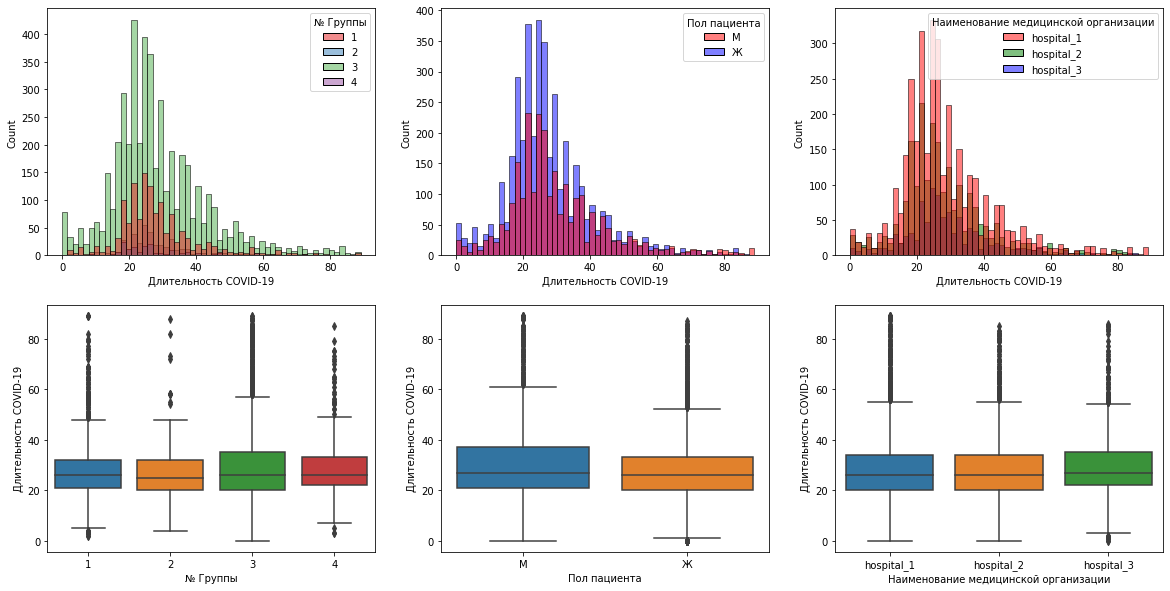

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
# график распределения длительности COVID-19 в зависимости от № группы
sns.histplot(
    data=df_unique,
    x = 'Длительность COVID-19',
    hue = '№ Группы',
    palette='Set1',
    ax=ax[0][0]
)
# график распределения длительности COVID-19 в зависимости от пола пациента
sns.histplot(
    data=df_unique,
    x = 'Длительность COVID-19',
    hue = 'Пол пациента',
    palette=['red', 'blue'],
    ax=ax[0][1]
)
# график распределения длительности COVID-19 в зависимости от медицинской органицации
sns.histplot(
    data=df_unique,
    x = 'Длительность COVID-19',
    hue = 'Наименование медицинской организации',
    palette=['red', 'green', 'blue'],
    ax=ax[0][2]
)
# график зависимости длительности COVID-19 в зависимости от № группы
sns.boxplot(
    data=df_unique,
    x = '№ Группы',
    y = 'Длительность COVID-19',
    ax=ax[1][0]
)
# график зависимости длительности COVID-19 в зависимости от пола паицента
sns.boxplot(
    data=df_unique,
    x = 'Пол пациента',
    y = 'Длительность COVID-19',
    ax=ax[1][1]
)
# график зависимости длительности COVID-19 в зависимости от медицинской организации
sns.boxplot(
    data=df_unique,
    x = 'Наименование медицинской организации',
    y = 'Длительность COVID-19',
    ax=ax[1][2]
)

## Оценим достоверность различий между типом препарата, полом пациента и наименованием организации относительно длительности COVID-19

In [42]:
# функция, которая оценивает значимость и строит графики анализа
def check_diff(df, x, y):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import normaltest, shapiro, ttest_ind, mannwhitneyu, kruskal, f_oneway
    # проверяем число категорий в независимой переменной, должно быть две
    if df[x].nunique() == 2:
        # создаем 2 датасета в звисимости от категорий
        sample_1 = df[df[x] == df[x].unique()[0]][y]
        sample_2 = df[df[x] == df[x].unique()[1]][y]
        # проверяем данные на нормальность распредления тест Колмогорова-Смирнова
        if df.shape[0]>5000:
            _, pvalue = normaltest(df[y])
            # данные распределены ненормально, проводим тест Манна-Уитни
            if pvalue < 0.05:
                U, p_value = mannwhitneyu(sample_1, sample_2)
                if p_value < 0.05:
                    print(f'Данные признака {y} имеют статистически значимые различия в зависимости от признака {x}.')
                    print(f'Значение U-Манна-Уитни равно {U}, p = {pvalue}')
                    sns.boxplot(data=df, x=x, y=y)
                    plt.annotate("*p<0.05", xy=(0.5, 0.95), xycoords='axes fraction', fontsize=10, ha='center', va='center')
                else:
                    print(f'Данные признака {y} не имеют статистически значимых различий в зависимости от признака {x}')  
            # данные распределены нормально, проводим T-тест
            else:
                T, p_value = ttest_ind(sample_1, sample_2)
                if p_value < 0.05:
                    print(f'Данные признака {y} имеют статистически значимые различия в зависимости от признака {x}.')
                    print(f'Значение T-теста равно {T}, p = {pvalue}')
                    sns.boxplot(data=df, x=x, y=y)
                    plt.annotate("*p<0.05", xy=(0.5, 0.95), xycoords='axes fraction', fontsize=10, ha='center', va='center')
                else:
                    print(f'Данные признака {y} не имеют статистически значимых различий в зависимости от признака {x}')
        # проверяем данные на нормальность распредления тест Шапиро
        else:
            _, pvalue = shapiro(df[y])
            # данные распределены ненормально, проводим тест Манна-Уитни
            if pvalue < 0.05:
                U, p_value = mannwhitneyu(sample_1, sample_2)
                if p_value < 0.05:
                    print(f'Данные признака {y} имеют статистически значимые различия в зависимости от признака {x}.')
                    print(f'Значение U-Манна-Уитни равно {U}, p = {pvalue}')
                    sns.boxplot(data=df, x=x, y=y)
                    plt.annotate("*p<0.05", xy=(0.5, 0.95), xycoords='axes fraction', fontsize=10, ha='center', va='center')
                else:
                    print(f'Данные признака {y} не имеют статистически значимых различий в зависимости от признака {x}')
            # данные распределены нормально, проводим T-тест
            else:
                T, p_value = ttest_ind(sample_1, sample_2)
                if p_value < 0.05:
                    print(f'Данные признака {y} имеют статистически значимые различия в зависимости от признака {x}.')
                    print(f'Значение Т-тест равно {T}, p = {pvalue}')
                    sns.boxplot(data=df, x=x, y=y)
                    plt.annotate("*p<0.05", xy=(0.5, 0.95), xycoords='axes fraction', fontsize=10, ha='center', va='center')
                else:
                    print(f'Данные признака {y} не имеют статистически значимых различий в зависимости от признака {x}')
    # оцениваем число категорий в независимой переменной - 3 категории
    elif df[x].nunique() == 3:
        sample_1 = df[df[x] == df[x].unique()[0]][y]
        sample_2 = df[df[x] == df[x].unique()[1]][y]
        sample_3 = df[df[x] == df[x].unique()[2]][y]
        if df.shape[0] > 5000:
            _, pvalue = normaltest(df[y])
            if pvalue < 0.05:
                H, pvalue = kruskal(sample_1, sample_2, sample_3)
                if pvalue<0.05:
                    print(f'Данные признака {y} имеют статистически значимые различия в зависимости от признака {x}.')
                    print(f'Значение Н-критерия равно {H}, p = {pvalue}')
                    sns.boxplot(data=df, x=x, y=y)
                    plt.annotate("*p<0.05", xy=(0.5, 0.95), xycoords='axes fraction', fontsize=10, ha='center', va='center')
                else:
                    print(f'Данные признака {y} не имеют статистически значимых различий в зависимости от признака {x}')
            else:
                F, pvalue = f_oneway(sample_1, sample_2, sample_3)
                if pvalue<0.05:
                    print(f'Данные признака {y} имеют статистически значимые различия в зависимости от признака {x}.')
                    print(f'Значение F-тест равно {F}, p = {pvalue}')
                    sns.boxplot(data=df, x=x, y=y)
                    plt.annotate("*p<0.05", xy=(0.5, 0.95), xycoords='axes fraction', fontsize=10, ha='center', va='center')
                else:
                    print(f'Данные признака {y} не имеют статистически значимых различий в зависимости от признака {x}')
        else:
            _, pvalue = shapiro(df[y])
            if pvalue < 0.05:
                H, pvalue = kruskal(sample_1, sample_2, sample_3)
                if pvalue<0.05:
                    print(f'Данные признака {y} имеют статистически значимые различия в зависимости от признака {x}.')
                    print(f'Значение Н-критерия равно {H}, p = {pvalue}')
                    sns.boxplot(data=df, x=x, y=y)
                    plt.annotate("*p<0.05", xy=(0.5, 0.95), xycoords='axes fraction', fontsize=10, ha='center', va='center')
                else:
                    print(f'Данные признака {y} не имеют статистически значимых различий в зависимости от признака {x}')
            else:
                F, pvalue = f_oneway(sample_1, sample_2, sample_3)
                if pvalue<0.05:
                    print(f'Данные признака {y} имеют статистически значимые различия в зависимости от признака {x}.')
                    print(f'Значение F-тест равно {F}, p = {pvalue}')
                    sns.boxplot(data=df, x=x, y=y)
                    plt.annotate("*p<0.05", xy=(0.5, 0.95), xycoords='axes fraction', fontsize=10, ha='center', va='center')
                else:
                    print(f'Данные признака {y} не имеют статистически значимых различий в зависимости от признака {x}')
    # оцениваем число категорий в независимой переменной - 4 категории
    elif df[x].nunique() == 4:
        sample_1 = df[df[x] == df[x].unique()[0]][y]
        sample_2 = df[df[x] == df[x].unique()[1]][y]
        sample_3 = df[df[x] == df[x].unique()[2]][y]
        sample_4 = df[df[x] == df[x].unique()[3]][y]
        if df.shape[0] > 5000:
            _, pvalue = normaltest(df[y])
            if pvalue < 0.05:
                H, pvalue = kruskal(sample_1, sample_2, sample_3, sample_4)
                if pvalue<0.05:
                    print(f'Данные признака {y} имеют статистически значимые различия в зависимости от признака {x}.')
                    print(f'Значение Н-критерия равно {H}, p = {pvalue}')
                    sns.boxplot(data=df, x=x, y=y)
                    plt.annotate("*p<0.05", xy=(0.5, 0.95), xycoords='axes fraction', fontsize=10, ha='center', va='center')
                else:
                    print(f'Данные признака {y} не имеют статистически значимых различий в зависимости от признака {x}')
            else:
                F, pvalue = f_oneway(sample_1, sample_2, sample_3, sample_4)
                if pvalue<0.05:
                    print(f'Данные признака {y} имеют статистически значимые различия в зависимости от признака {x}.')
                    print(f'Значение F-тест равно {F}, p = {pvalue}')
                    sns.boxplot(data=df, x=x, y=y)
                    plt.annotate("*p<0.05", xy=(0.5, 0.95), xycoords='axes fraction', fontsize=10, ha='center', va='center')
                else:
                    print(f'Данные признака {y} не имеют статистически значимых различий в зависимости от признака {x}')
        else:
            _, pvalue = shapiro(df[y])
            if pvalue < 0.05:
                H, pvalue = kruskal(sample_1, sample_2, sample_3, sample_4)
                if pvalue<0.05:
                    print(f'Данные признака {y} имеют статистически значимые различия в зависимости от признака {x}.')
                    print(f'Значение Н-критерия равно {H}, p = {pvalue}')
                    sns.boxplot(data=df, x=x, y=y)
                    plt.annotate("*p<0.05", xy=(0.5, 0.95), xycoords='axes fraction', fontsize=10, ha='center', va='center')
                else:
                    print(f'Данные признака {y} не имеют статистически значимых различий в зависимости от признака {x}')
            else:
                F, pvalue = f_oneway(sample_1, sample_2, sample_3, sample_4)
                if pvalue<0.05:
                    print(f'Данные признака {y} имеют статистически значимые различия в зависимости от признака {x}.')
                    print(f'Значение F-тест равно {F}, p = {pvalue}')
                    sns.boxplot(data=df, x=x, y=y)
                    plt.annotate("*p<0.05", xy=(0.5, 0.95), xycoords='axes fraction', fontsize=10, ha='center', va='center')
                else:
                    print(f'Данные признака {y} не имеют статистически значимых различий в зависимости от признака {x}')

### Оцениваем различия в общей выборке

In [43]:
# Оцениваем статистическую значимость типа препарата и длительности COVID-19
check_diff(df = df_unique, x='№ Группы', y='Длительность COVID-19')

Данные признака Длительность COVID-19 не имеют статистически значимых различий в зависимости от признака № Группы


Данные признака Длительность COVID-19 имеют статистически значимые различия в зависимости от признака Пол пациента.
Значение U-Манна-Уитни равно 5708259.0, p = 0.0


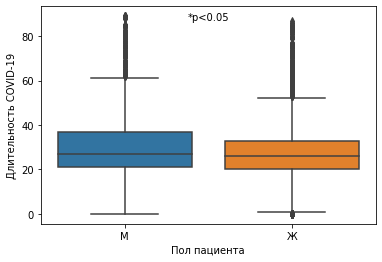

In [44]:
# Оцениваем статистическую значимость пола пациента и длительности COVID-19
check_diff(df = df_unique, x='Пол пациента', y='Длительность COVID-19')

In [45]:
df_unique.groupby('Пол пациента')['Длительность COVID-19'].median()

Пол пациента
Ж    26.0
М    27.0
Name: Длительность COVID-19, dtype: float64

Данные признака Длительность COVID-19 имеют статистически значимые различия в зависимости от признака Наименование медицинской организации.
Значение Н-критерия равно 11.347228489463145, p = 0.0034354263394150678


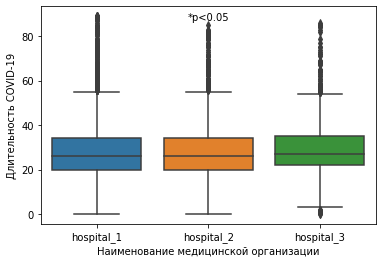

In [46]:
# Оцениваем статистическую значимость пола пациента и длительности COVID-19
check_diff(df = df_unique, x='Наименование медицинской организации', y='Длительность COVID-19')

In [47]:
df_unique.groupby('Наименование медицинской организации')['Длительность COVID-19'].median()

Наименование медицинской организации
hospital_1    26.0
hospital_2    26.0
hospital_3    27.0
Name: Длительность COVID-19, dtype: float64

**Вывод:** при оценке данных определено, что тип лекарственного препарата не влияет на длительность COVID-19. Мужчины статистически значимо болеют дольше, чем женщины. Длительность COVID-19 в hospital_3 больше всего.

### Оцениваем различия в зависимости от числа развившихся ПКС

In [74]:
df_unique[df_unique['ПКС_2'] == 'no']

,№ Группы,Возраст пациента,Пол пациента,Наименование медицинской организации,Длительность COVID-19,ПКС_1,ПКС_2,ПКС_3,ПКС_4,Число дней до 1 ПКС,Число дней до 2 ПКС,Число дней до 3 ПКС,Число дней до 4 ПКС
2806,3,78,М,hospital_1,27,J41.0,no,no,no,55,no,no,no
7466,1,71,Ж,hospital_2,64,M13.9,no,no,no,172,no,no,no
9774,3,68,Ж,hospital_3,53,G47.9,no,no,no,174,no,no,no
7890,3,68,М,hospital_2,23,I67.8,no,no,no,168,no,no,no
8478,1,60,М,hospital_3,47,J42,no,no,no,34,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8077,3,42,М,hospital_2,37,G90.9,no,no,no,51,no,no,no
2381,4,55,М,hospital_1,25,I11.9,no,no,no,132,no,no,no
2026,3,45,М,hospital_1,12,J41.0,no,no,no,77,no,no,no
2339,3,50,Ж,hospital_1,34,I67.8,no,no,no,142,no,no,no


In [80]:
df_unique

,№ Группы,Возраст пациента,Пол пациента,Наименование медицинской организации,Длительность COVID-19,ПКС_1,ПКС_2,ПКС_3,ПКС_4,Число дней до 1 ПКС,Число дней до 2 ПКС,Число дней до 3 ПКС,Число дней до 4 ПКС
4070,1,52,М,hospital_1,43,J90,J94.8,no,no,132,136,no,no
2806,3,78,М,hospital_1,27,J41.0,no,no,no,55,no,no,no
7466,1,71,Ж,hospital_2,64,M13.9,no,no,no,172,no,no,no
9774,3,68,Ж,hospital_3,53,G47.9,no,no,no,174,no,no,no
6564,3,31,Ж,hospital_2,1,N91.1,I10,no,no,37,156,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,3,45,М,hospital_1,12,J41.0,no,no,no,77,no,no,no
4364,3,57,М,hospital_1,43,N17.0,N17.0,no,no,165,165,no,no
2339,3,50,Ж,hospital_1,34,I67.8,no,no,no,142,no,no,no
757,1,73,М,hospital_1,24,I44.7,no,no,no,137,no,no,no


In [106]:
# Создаем 4 датасета по числу ПКС
pcs_1 = df_unique[(df_unique['ПКС_2'] == 'no') & (df_unique['ПКС_3'] == 'no') & (df_unique['ПКС_4'] == 'no')]
pcs_2 = df_unique[df_unique['ПКС_2'] != 'no']
pcs_3 = df_unique[df_unique['ПКС_3'] != 'no']
pcs_4 = df_unique[df_unique['ПКС_4'] != 'no']

In [108]:
# Переводим данные по ПКС из object в int
pcs_2['Число дней до 2 ПКС'] = pcs_2['Число дней до 2 ПКС'].astype('int64')
pcs_3['Число дней до 3 ПКС'] = pcs_3['Число дней до 3 ПКС'].astype('int64')
pcs_4['Число дней до 4 ПКС'] = pcs_4['Число дней до 4 ПКС'].astype('int64')

/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_31672/1263655431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pcs_2['Число дней до 2 ПКС'] = pcs_2['Число дней до 2 ПКС'].astype('int64')
/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_31672/1263655431.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pcs_3['Число дней до 3 ПКС'] = pcs_3['Число дней до 3 ПКС'].astype('int64')
/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_31672/1263655431.py:4: SettingWithCopyWarning

#### В зависимости от пола

Данные признака Длительность COVID-19 имеют статистически значимые различия в зависимости от признака Пол пациента.
Значение U-Манна-Уитни равно 2895191.5, p = 0.0
None


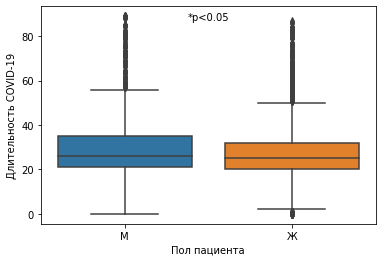

In [49]:
# Зависимость пола пациента и числа ПКС на длительность СCOVID-19
print(check_diff(df=pcs_1, x='Пол пациента', y='Длительность COVID-19'))

In [50]:
print(check_diff(df=pcs_2, x='Пол пациента', y='Длительность COVID-19'))

Данные признака Длительность COVID-19 не имеют статистически значимых различий в зависимости от признака Пол пациента
None


In [51]:
print(check_diff(df=pcs_3, x='Пол пациента', y='Длительность COVID-19'))

Данные признака Длительность COVID-19 не имеют статистически значимых различий в зависимости от признака Пол пациента
None


Данные признака Длительность COVID-19 имеют статистически значимые различия в зависимости от признака Пол пациента.
Значение U-Манна-Уитни равно 18659.0, p = 1.2098910762148307e-09
None


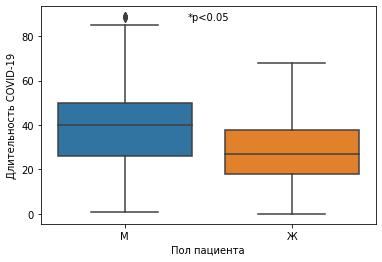

In [52]:
print(check_diff(df=pcs_4, x='Пол пациента', y='Длительность COVID-19'))

In [53]:
pcs_4.groupby('Пол пациента')['Длительность COVID-19'].median()

Пол пациента
Ж    27.0
М    40.0
Name: Длительность COVID-19, dtype: float64

**Вывод:** Больше всего ПКС развивается у мужчин с длительностью COVID-19 по медианому значению - 38,5 дней.

#### В заисимости от типа принимаемого препарата

In [54]:
print(check_diff(df=pcs_1, x='№ Группы', y='Длительность COVID-19'))

Данные признака Длительность COVID-19 не имеют статистически значимых различий в зависимости от признака № Группы
None


In [55]:
print(check_diff(df=pcs_2, x='№ Группы', y='Длительность COVID-19'))

Данные признака Длительность COVID-19 не имеют статистически значимых различий в зависимости от признака № Группы
None


Данные признака Длительность COVID-19 имеют статистически значимые различия в зависимости от признака № Группы.
Значение Н-критерия равно 11.702120856980665, p = 0.00847644817210891
None


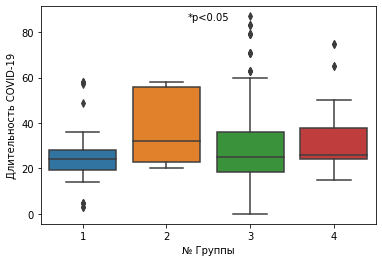

In [56]:
print(check_diff(df=pcs_3, x='№ Группы', y='Длительность COVID-19'))

Данные признака Длительность COVID-19 имеют статистически значимые различия в зависимости от признака № Группы.
Значение Н-критерия равно 11.245764545247564, p = 0.010468524244361245
None


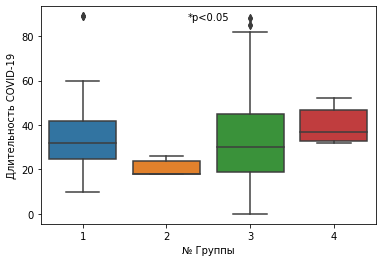

In [57]:
print(check_diff(df=pcs_4, x='№ Группы', y='Длительность COVID-19'))

**Вывод:** При развитии 3 ПКС наибольщая длительность COVID-19 наибольшая при приеме препарата из группы №2, а наименьшая из групп 1 и 3.

При развитии 4 ПКС наибольшая длительность COVID-19 при приеме препарата из группы №4, а наименьшая из группы 2.

#### В зависимости от медицинской организации

Данные признака Длительность COVID-19 имеют статистически значимые различия в зависимости от признака Наименование медицинской организации.
Значение Н-критерия равно 13.523305598899764, p = 0.001157314783051552
None


Наименование медицинской организации
hospital_1    25.0
hospital_2    25.0
hospital_3    27.0
Name: Длительность COVID-19, dtype: float64

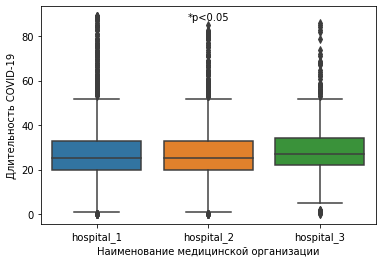

In [58]:
print(check_diff(df=pcs_1, x='Наименование медицинской организации', y='Длительность COVID-19'))
display(pcs_1.groupby('Наименование медицинской организации')['Длительность COVID-19'].median())

In [59]:
print(check_diff(df=pcs_2, x='Наименование медицинской организации', y='Длительность COVID-19'))
display(pcs_2.groupby('Наименование медицинской организации')['Длительность COVID-19'].median())

Данные признака Длительность COVID-19 не имеют статистически значимых различий в зависимости от признака Наименование медицинской организации
None


Наименование медицинской организации
hospital_1    27.0
hospital_2    27.0
hospital_3    27.0
Name: Длительность COVID-19, dtype: float64

In [60]:
print(check_diff(df=pcs_3, x='Наименование медицинской организации', y='Длительность COVID-19'))
display(pcs_3.groupby('Наименование медицинской организации')['Длительность COVID-19'].median())

Данные признака Длительность COVID-19 не имеют статистически значимых различий в зависимости от признака Наименование медицинской организации
None


Наименование медицинской организации
hospital_1    25.0
hospital_2    24.0
hospital_3    28.0
Name: Длительность COVID-19, dtype: float64

In [61]:
print(check_diff(df=pcs_4, x='Наименование медицинской организации', y='Длительность COVID-19'))
display(pcs_4.groupby('Наименование медицинской организации')['Длительность COVID-19'].median())

Данные признака Длительность COVID-19 не имеют статистически значимых различий в зависимости от признака Наименование медицинской организации
None


Наименование медицинской организации
hospital_1    31.0
hospital_2    33.0
hospital_3    26.0
Name: Длительность COVID-19, dtype: float64

**Вывод:** Дольше всего протекает COVID-19 в медицинской организации hospital_3 при развитии 1 ПКС. В остальных случаях различий не получено.

## Оценим частоту встречаемости различных ПКС
**Наиболее часто встречающиеся ПКС**

<AxesSubplot:title={'center':'Частота встречаемости 4 ПКС после COVID-19'}, ylabel='Количество случаев'>

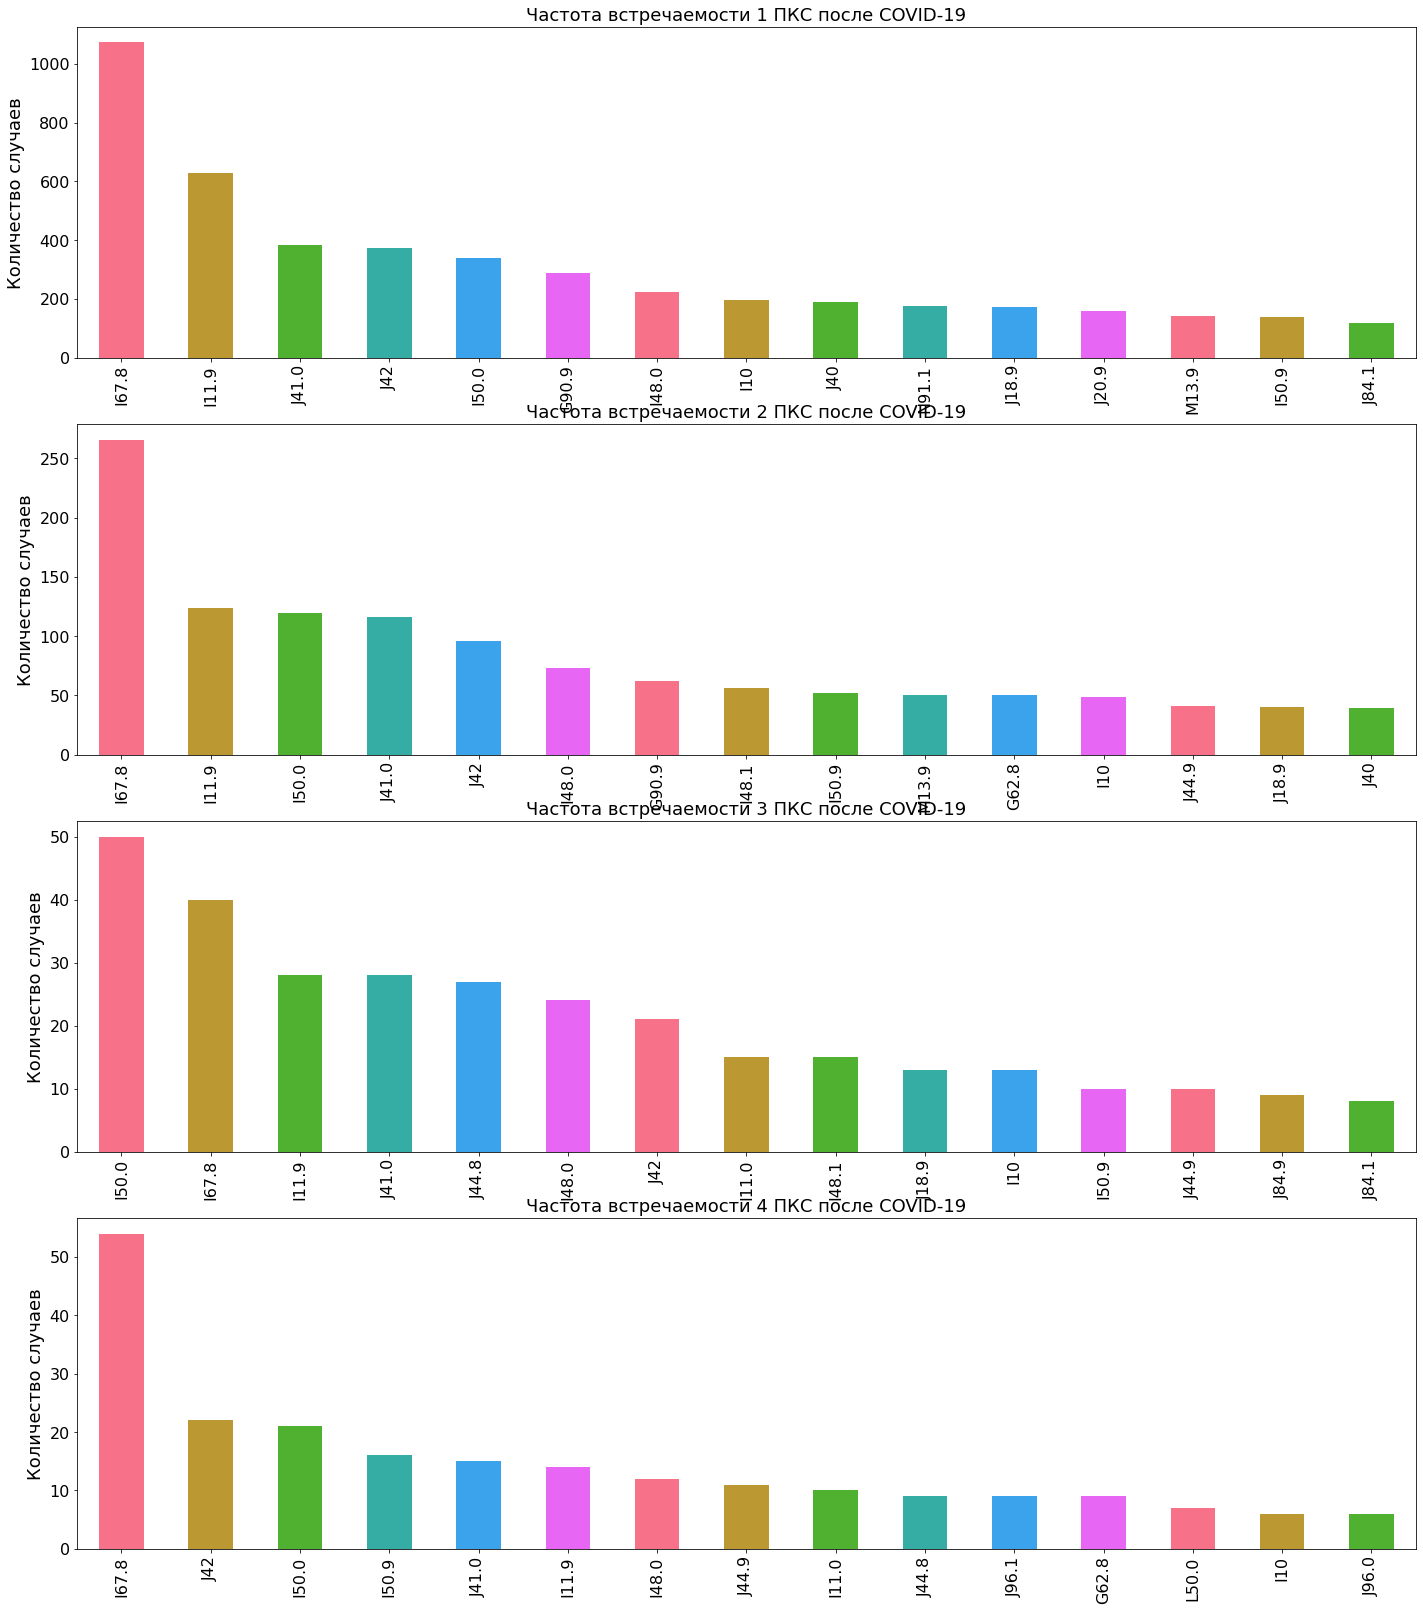

In [109]:
# Исходя из 1 ПКС топ-15
fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize=(24,28))
ax[0].set_title('Частота встречаемости 1 ПКС после COVID-19', fontsize=18)
ax[0].set_ylabel('Количество случаев', fontsize=18)
ax[0].tick_params(labelsize=16)
sns.color_palette('husl')
df_unique['ПКС_1'].value_counts()[:15].plot(kind='bar', color=sns.color_palette('husl'), ax=ax[0])

# Исходя из 2 ПКС топ-15
ax[1].set_title('Частота встречаемости 2 ПКС после COVID-19', fontsize=18)
ax[1].set_ylabel('Количество случаев', fontsize=18)
ax[1].tick_params(labelsize=16)
sns.color_palette('husl')
df_unique[df_unique['ПКС_2'] != 'no']['ПКС_2'].value_counts()[:15].plot(kind='bar', color=sns.color_palette('husl'), ax=ax[1])

# Исходя из 3 ПКС топ-15
ax[2].set_title('Частота встречаемости 3 ПКС после COVID-19', fontsize=18)
ax[2].set_ylabel('Количество случаев', fontsize=18)
ax[2].tick_params(labelsize=16)
sns.color_palette('husl')
df_unique[df_unique['ПКС_3'] != 'no']['ПКС_3'].value_counts()[:15].plot(kind='bar', color=sns.color_palette('husl'), ax=ax[2])

# Исходя из 4 ПКС топ-15
ax[3].set_title('Частота встречаемости 4 ПКС после COVID-19', fontsize=18)
ax[3].set_ylabel('Количество случаев', fontsize=18)
ax[3].tick_params(labelsize=16)
sns.color_palette('husl')
df_unique[df_unique['ПКС_4'] != 'no']['ПКС_4'].value_counts()[:15].plot(kind='bar', color=sns.color_palette('husl'), ax=ax[3])

In [111]:
# создаем списки из топ-10 ПКС
top_10_pcs_1 = [
    'I67.8','I11.9','J41.0','J42','I50.0','G90.9','I48.0','I10','J40','N91.1'
]
top_10_pcs_2 = [
    'I67.8','I11.9','I50.0','J41.0','J42','I48.0','G90.9','I48.1','I50.9','M13.9'
]
top_10_pcs_3 = [
    'I50.0','I67.8','I11.9','J41.0','J44.8','J48.0','J42','I11.0','I48.1','J18.9'
]
top_10_pcs_4 = [
    'I67.8', 'J42','I50.0','I50.9','J41.0','I11.9','I48.0','J44.9','I11.0','J44.8'
]

In [112]:
# Проведем корреляционный анализ влияиния длительности COVID-19 на время до развития 1-4 ПКС
display(pcs_1[['Длительность COVID-19', 'Число дней до 1 ПКС']].corr(method='spearman'))
display(pcs_2[['Длительность COVID-19', 'Число дней до 1 ПКС']].corr(method='spearman'))
display(pcs_3[['Длительность COVID-19', 'Число дней до 1 ПКС']].corr(method='spearman'))
display(pcs_3[['Длительность COVID-19', 'Число дней до 1 ПКС']].corr(method='spearman'))

,Длительность COVID-19,Число дней до 1 ПКС
Длительность COVID-19,1.000000,-0.008015
Число дней до 1 ПКС,-0.008015,1.000000


,Длительность COVID-19,Число дней до 1 ПКС
Длительность COVID-19,1.000000,-0.028224
Число дней до 1 ПКС,-0.028224,1.000000


,Длительность COVID-19,Число дней до 1 ПКС
Длительность COVID-19,1.000000,0.137455
Число дней до 1 ПКС,0.137455,1.000000


,Длительность COVID-19,Число дней до 1 ПКС
Длительность COVID-19,1.000000,0.137455
Число дней до 1 ПКС,0.137455,1.000000


**Вывод:** значимых корреляций длительности COVID-19 до развития ПКС не выявлено.

Данные признака Число дней до 1 ПКС имеют статистически значимые различия в зависимости от признака Пол пациента.
Значение U-Манна-Уитни равно 1698958.0, p = 4.0861597757730584e-36


Пол пациента
Ж    95.5
М    88.0
Name: Число дней до 1 ПКС, dtype: float64

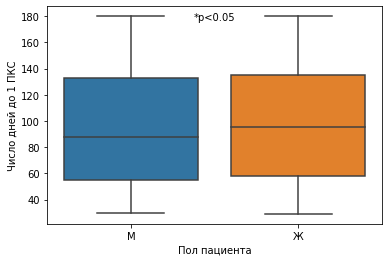

In [113]:
check_diff(df=pcs_1, x='Пол пациента', y='Число дней до 1 ПКС')
display(pcs_1.groupby('Пол пациента')['Число дней до 1 ПКС'].median())

Данные признака Число дней до 2 ПКС имеют статистически значимые различия в зависимости от признака Пол пациента.
Значение U-Манна-Уитни равно 412968.5, p = 4.592274116347129e-22


Пол пациента
Ж    109.0
М    102.0
Name: Число дней до 2 ПКС, dtype: float64

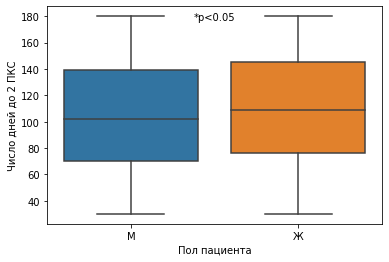

In [114]:
check_diff(df=pcs_2, x='Пол пациента', y='Число дней до 2 ПКС')
display(pcs_2.groupby('Пол пациента')['Число дней до 2 ПКС'].median())

In [116]:
check_diff(df=pcs_3, x='Пол пациента', y='Число дней до 3 ПКС')

Данные признака Число дней до 3 ПКС не имеют статистически значимых различий в зависимости от признака Пол пациента


Данные признака Число дней до 4 ПКС имеют статистически значимые различия в зависимости от признака Пол пациента.
Значение U-Манна-Уитни равно 10952.0, p = 3.9745238211708056e-08


Пол пациента
Ж    124.0
М    107.0
Name: Число дней до 4 ПКС, dtype: float64

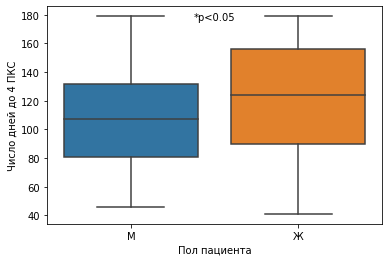

In [117]:
check_diff(df=pcs_4, x='Пол пациента', y='Число дней до 4 ПКС')
display(pcs_4.groupby('Пол пациента')['Число дней до 4 ПКС'].median())

**Вывод:** У женщин ПКС развивается на 7-14 дней позже, чем у мужчин.

### Создадим dummy признаки по топ-10 из каждого ПКСов

In [126]:
# Создаем столбцы из top-10 по ПКС
for d in top_10_pcs_1:
    df_unique['ПКС_1_'+d] = 0
for d in top_10_pcs_2:
    df_unique['ПКС_2_'+d] = 0
for d in top_10_pcs_3:
    df_unique['ПКС_3_'+d] = 0
for d in top_10_pcs_4:
    df_unique['ПКС_4_'+d] = 0


In [127]:
for d in top_10_pcs_1:
    for i in list(df_unique.index):
        if df_unique['ПКС_1'][i] == d:
            df_unique['ПКС_1_'+d][i] = 1

/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_31672/3956385105.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['ПКС_1_'+d][i] = 1


In [129]:
for d in top_10_pcs_2:
    for i in list(df_unique.index):
        if df_unique['ПКС_2'][i] == d:
            df_unique['ПКС_2_'+d][i] = 1

/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_31672/2505342714.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['ПКС_2_'+d][i] = 1


In [130]:
for d in top_10_pcs_3:
    for i in list(df_unique.index):
        if df_unique['ПКС_3'][i] == d:
            df_unique['ПКС_3_'+d][i] = 1

/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_31672/2021344625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['ПКС_3_'+d][i] = 1


In [131]:
for d in top_10_pcs_4:
    for i in list(df_unique.index):
        if df_unique['ПКС_4'][i] == d:
            df_unique['ПКС_4_'+d][i] = 1

/var/folders/rh/dqxhnmvx7wn4bd9fh2gs84p40000gn/T/ipykernel_31672/927060071.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['ПКС_4_'+d][i] = 1


In [133]:
df_unique = df_unique.drop(['№ Группы', 'Наименование медицинской организации', 'ПКС_1', 'ПКС_2', 'ПКС_3', 'ПКС_4'], axis=1)
df_unique.head()

,Возраст пациента,Пол пациента,Длительность COVID-19,Число дней до 1 ПКС,Число дней до 2 ПКС,Число дней до 3 ПКС,Число дней до 4 ПКС,ПКС_1_I67.8,ПКС_1_I11.9,ПКС_1_J41.0,...,ПКС_4_I67.8,ПКС_4_J42,ПКС_4_I50.0,ПКС_4_I50.9,ПКС_4_J41.0,ПКС_4_I11.9,ПКС_4_I48.0,ПКС_4_J44.9,ПКС_4_I11.0,ПКС_4_J44.8
4070,52,М,43,132,136,no,no,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2806,78,М,27,55,no,no,no,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7466,71,Ж,64,172,no,no,no,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9774,68,Ж,53,174,no,no,no,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6564,31,Ж,1,37,156,no,no,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
# Кодируем признак "Пол пациента"
df_unique['Пол пациента'] = df_unique['Пол пациента'].apply(lambda x: 1 if x == 'М' else 0)
# Кодируем дни из 'no' в ноль
df_unique['Число дней до 1 ПКС'] = df_unique['Число дней до 1 ПКС'].apply(lambda x: 0 if x == 'no' else x)
df_unique['Число дней до 2 ПКС'] = df_unique['Число дней до 2 ПКС'].apply(lambda x: 0 if x == 'no' else x)
df_unique['Число дней до 3 ПКС'] = df_unique['Число дней до 3 ПКС'].apply(lambda x: 0 if x == 'no' else x)
df_unique['Число дней до 4 ПКС'] = df_unique['Число дней до 4 ПКС'].apply(lambda x: 0 if x == 'no' else x)

In [135]:
df_unique.head()

,Возраст пациента,Пол пациента,Длительность COVID-19,Число дней до 1 ПКС,Число дней до 2 ПКС,Число дней до 3 ПКС,Число дней до 4 ПКС,ПКС_1_I67.8,ПКС_1_I11.9,ПКС_1_J41.0,...,ПКС_4_I67.8,ПКС_4_J42,ПКС_4_I50.0,ПКС_4_I50.9,ПКС_4_J41.0,ПКС_4_I11.9,ПКС_4_I48.0,ПКС_4_J44.9,ПКС_4_I11.0,ПКС_4_J44.8
4070,52,1,43,132,136,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2806,78,1,27,55,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7466,71,0,64,172,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9774,68,0,53,174,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6564,31,0,1,37,156,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [136]:
# Сохраняем полученный датасет
df_unique.to_csv('data/unique_df_1.csv')

# Применение ML и DL

In [138]:
# Создаем датасет для кластеризации
clust_df = df_unique.copy()
clust_df.head()

,Возраст пациента,Пол пациента,Длительность COVID-19,Число дней до 1 ПКС,Число дней до 2 ПКС,Число дней до 3 ПКС,Число дней до 4 ПКС,ПКС_1_I67.8,ПКС_1_I11.9,ПКС_1_J41.0,...,ПКС_4_I67.8,ПКС_4_J42,ПКС_4_I50.0,ПКС_4_I50.9,ПКС_4_J41.0,ПКС_4_I11.9,ПКС_4_I48.0,ПКС_4_J44.9,ПКС_4_I11.0,ПКС_4_J44.8
4070,52,1,43,132,136,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2806,78,1,27,55,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7466,71,0,64,172,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9774,68,0,53,174,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6564,31,0,1,37,156,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Baseline

In [139]:
# Стандартизуем данные с помощью StandardScale
from sklearn import preprocessing
cols = list(clust_df.columns)
scale = preprocessing.StandardScaler()
clust_df_scale = pd.DataFrame(scale.fit_transform(clust_df), columns=cols)
clust_df_scale.head()

,Возраст пациента,Пол пациента,Длительность COVID-19,Число дней до 1 ПКС,Число дней до 2 ПКС,Число дней до 3 ПКС,Число дней до 4 ПКС,ПКС_1_I67.8,ПКС_1_I11.9,ПКС_1_J41.0,...,ПКС_4_I67.8,ПКС_4_J42,ПКС_4_I50.0,ПКС_4_I50.9,ПКС_4_J41.0,ПКС_4_I11.9,ПКС_4_I48.0,ПКС_4_J44.9,ПКС_4_I11.0,ПКС_4_J44.8
0,-0.661817,1.266824,1.017748,0.941769,1.962234,-0.266229,-0.217897,-0.437808,-0.322369,-0.247482,...,-0.090337,-0.057522,-0.056195,-0.049033,-0.047472,-0.045859,-0.042451,-0.040641,-0.038746,-0.036755
1,0.951506,1.266824,-0.126633,-0.835647,-0.572740,-0.266229,-0.217897,-0.437808,-0.322369,4.040702,...,-0.090337,-0.057522,-0.056195,-0.049033,-0.047472,-0.045859,-0.042451,-0.040641,-0.038746,-0.036755
2,0.517150,-0.789376,2.519749,1.865102,-0.572740,-0.266229,-0.217897,-0.437808,-0.322369,-0.247482,...,-0.090337,-0.057522,-0.056195,-0.049033,-0.047472,-0.045859,-0.042451,-0.040641,-0.038746,-0.036755
3,0.330997,-0.789376,1.732987,1.911269,-0.572740,-0.266229,-0.217897,-0.437808,-0.322369,-0.247482,...,-0.090337,-0.057522,-0.056195,-0.049033,-0.047472,-0.045859,-0.042451,-0.040641,-0.038746,-0.036755
4,-1.964886,-0.789376,-1.986252,-1.251147,2.335024,-0.266229,-0.217897,-0.437808,-0.322369,-0.247482,...,-0.090337,-0.057522,-0.056195,-0.049033,-0.047472,-0.045859,-0.042451,-0.040641,-0.038746,-0.036755


In [140]:
# Используем метод главных компонент для понижения размерности датасета
from sklearn import decomposition
PCA = decomposition.PCA(n_components=2)
df_pca = PCA.fit_transform(clust_df_scale)
print('Описываемая дисперсия по первому признаку -', round(PCA.explained_variance_ratio_[0],2))

Описываемая дисперсия по первому признаку - 0.04


<AxesSubplot:xlabel='axis-1', ylabel='axis-2'>

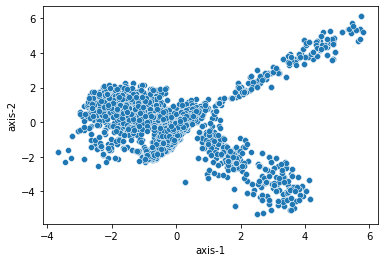

In [141]:
# создаем датасет из 2 главных компонент
df_pca = pd.DataFrame(df_pca, columns=['axis-1', 'axis-2'])
sns.scatterplot(
    data=df_pca,
    x='axis-1',
    y='axis-2'
)

### Определяем оптимальное число кластеров с использованием KMeans

In [142]:
# Оперделеим оптимальное число кластеров
import plotly.graph_objects as go
from sklearn import metrics, cluster
score = []
for i in range(2,11):
    kmean = cluster.KMeans(random_state=42, n_clusters=i)
    kmean.fit(df_pca)
    sil_score = metrics.silhouette_score(df_pca, kmean.labels_)
    score.append(sil_score)

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(2,11), y=score, mode='lines+markers'))
fig.update_layout(
    title='Зависимость силуэта от числа кластеров',
    xaxis_title='Количество кластеров',
    yaxis_title='Силуэт'
)
fig.show()
print('Максимальное значение силуэта равно', np.max(score))

Максимальное значение силуэта равно 0.7023244148040015


In [143]:
kmean = cluster.KMeans(n_clusters=2, random_state=42)
kmean.fit(df_pca)
df_pca['kmean_labels'] = kmean.labels_

<AxesSubplot:xlabel='axis-1', ylabel='axis-2'>

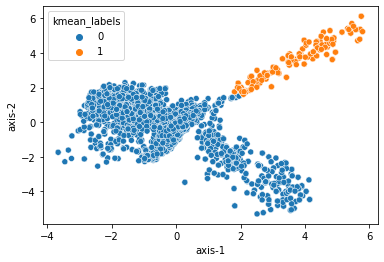

In [144]:
sns.scatterplot(
    data=df_pca,
    x='axis-1',
    y='axis-2',
    hue='kmean_labels'
)

## Сравниваем модели с Baseline

In [145]:
# Сделаем кластеризацию с помощью понижения размерности t-SNE
from sklearn import manifold
tsne = manifold.TSNE(2,perplexity=50, random_state=100)
ss = tsne.fit_transform(clust_df)
print('Значение дивергенции Кульбака-Лейблера', round(tsne.kl_divergence_,2))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



Значение дивергенции Кульбака-Лейблера 0.87


In [147]:
df_tsne = pd.DataFrame(ss, columns=['tsne_1', 'tsne_2'])
df_tsne.head()

,tsne_1,tsne_2
0,59.073448,-2.090744
1,-7.617505,-45.252773
2,-29.969030,43.108414
3,-29.029875,44.196293
4,73.859604,26.411646


<AxesSubplot:xlabel='tsne_1', ylabel='tsne_2'>

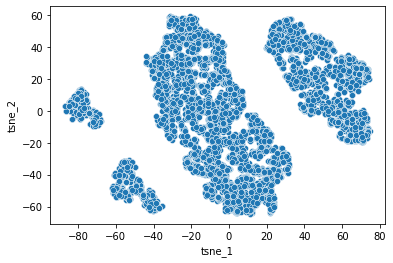

In [149]:
sns.scatterplot(
    data=df_tsne,
    x='tsne_1',
    y='tsne_2'
)

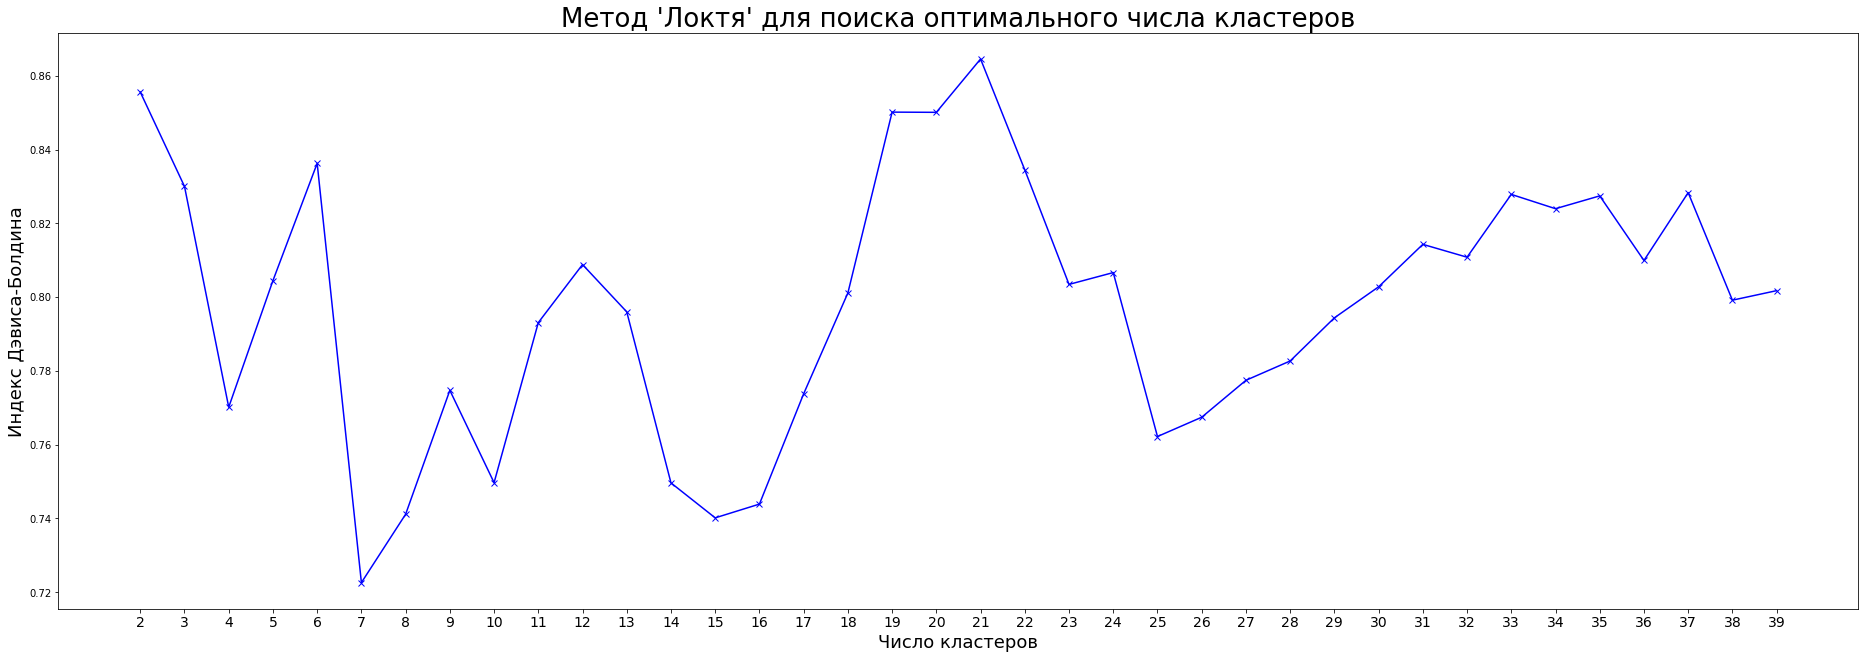

In [150]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score

# Создание списка для сохранения значений индекса Дэвиса-Болдина
davies_bouldin_scores = []

# Запуск агломеративной кластеризации для различного числа кластеров
for k in range(2, 40):
    clustering = AgglomerativeClustering(n_clusters=k)
    clustering.fit(ss)
    davies_bouldin_scores.append(davies_bouldin_score(df_tsne, clustering.labels_))

# Построение графика зависимости значения функционала качества кластеризации от числа кластеров
fig = plt.figure(figsize=(25,8))
fig.add_axes([0,0,1,1])
plt.plot(range(2, 40), davies_bouldin_scores, marker='x', color='blue')
plt.xlabel("Число кластеров", fontsize=18)
plt.ylabel("Индекс Дэвиса-Болдина", fontsize=18)
plt.title("Метод 'Локтя' для поиска оптимального числа кластеров", fontsize = 26)
plt.xticks(range(2, 40), fontsize=14)
plt.show()

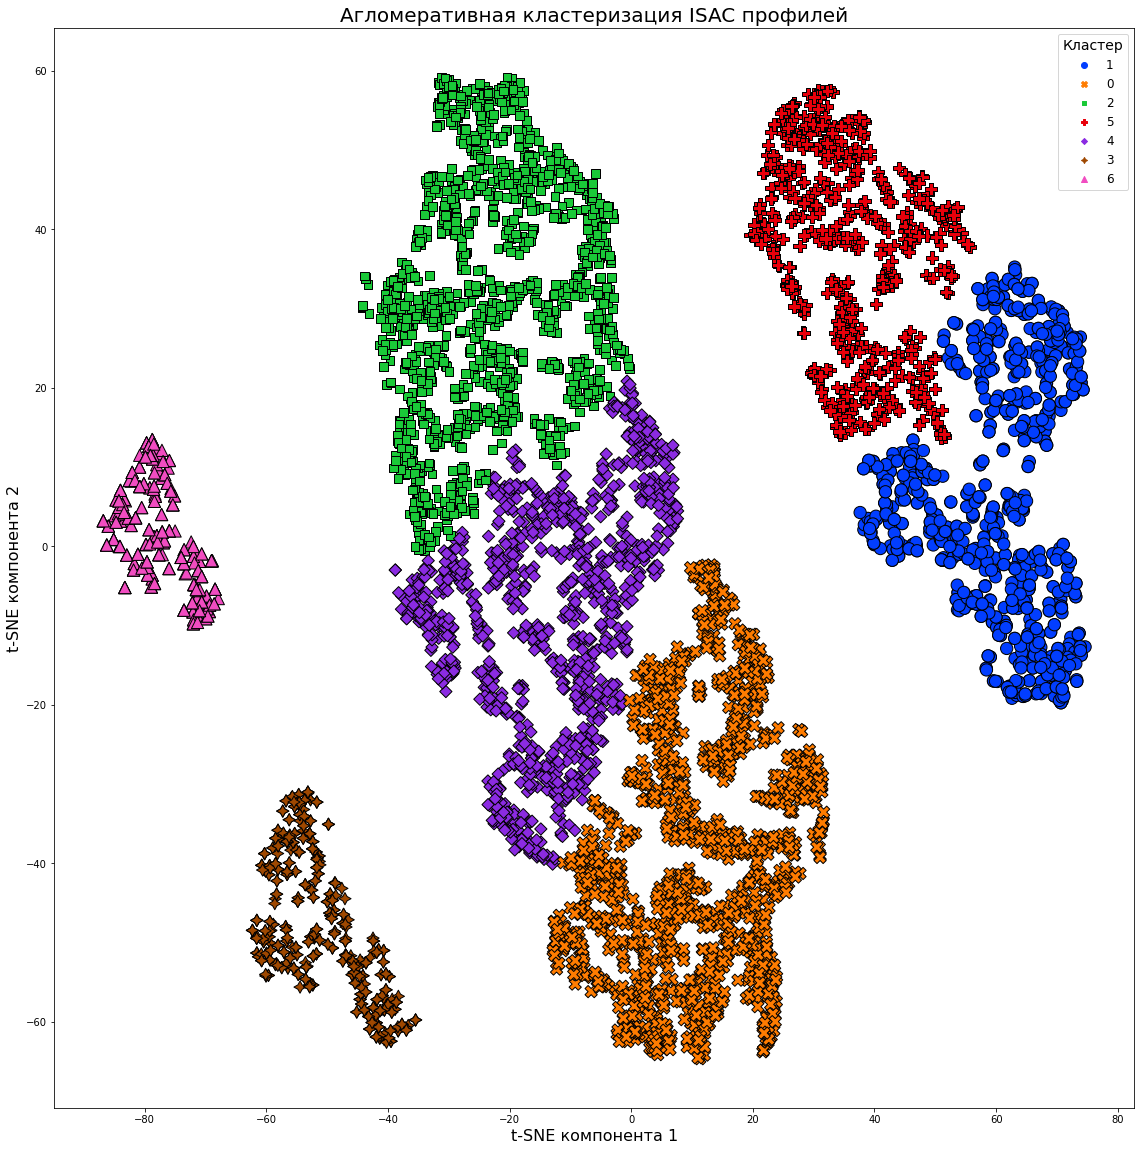

In [153]:
# Используем агломеративную кластеризацию
from sklearn import cluster
df_tsne = pd.DataFrame(ss, columns=['axis-1', 'axis-2'])
ag_clust = cluster.AgglomerativeClustering(n_clusters=7)
clust_ag = ag_clust.fit_predict(df_tsne)
fig = plt.figure(figsize=(15, 15))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Агломеративная кластеризация ISAC профилей', fontsize=20)
ax.set_xlabel('t-SNE компонента 1', fontsize=16)
ax.set_ylabel('t-SNE компонента 2', fontsize=16)
sns.scatterplot(
    data=df_tsne, 
    x='axis-1', 
    y='axis-2', 
    hue=ag_clust.labels_.astype('str'), 
    palette='bright', 
    style=ag_clust.labels_.astype('str'),
    s=150,
    edgecolor='black',
    linewidth=1
    )
ax.legend(title='Кластер', fontsize=12, title_fontsize=14)

In [155]:
# ИСпользуем спектральную кластеризацию
from sklearn.cluster import SpectralClustering
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt


# создаем модель спектральной кластеризации
model = SpectralClustering(n_clusters=7, affinity='nearest_neighbors',
                           assign_labels='kmeans')

# прогнозируем кластеры
y_pred = model.fit_predict(df_tsne)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



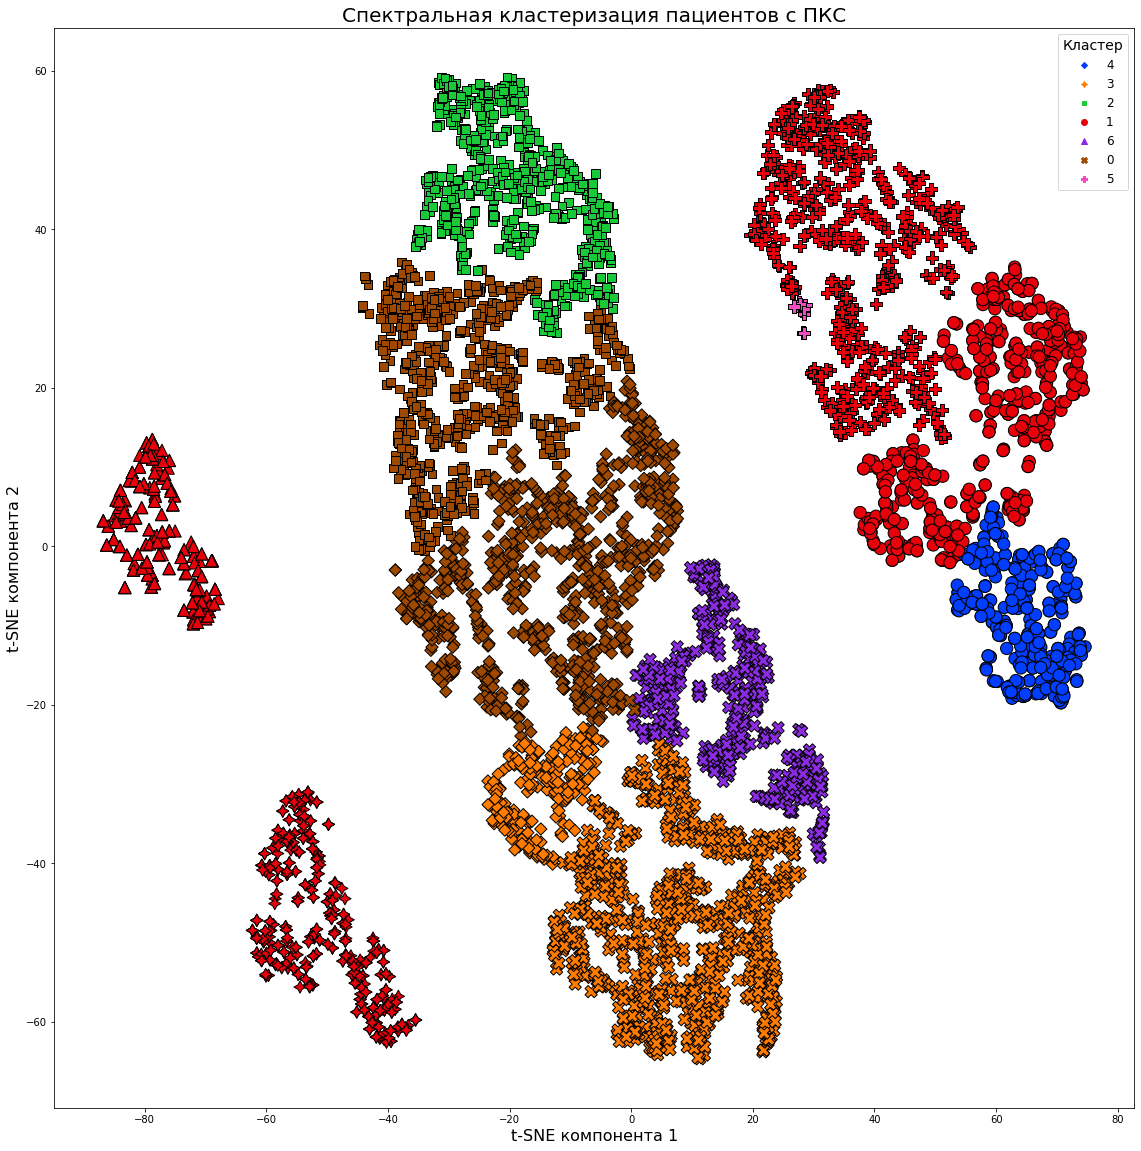

In [161]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Спектральная кластеризация пациентов с ПКС', fontsize=20)
ax.set_xlabel('t-SNE компонента 1', fontsize=16)
ax.set_ylabel('t-SNE компонента 2', fontsize=16)
sns.scatterplot(
    data=df_tsne, 
    x='axis-1', 
    y='axis-2', 
    hue=y_pred.astype('str'), 
    palette='bright', 
    style=ag_clust.labels_.astype('str'),
    s=150,
    edgecolor='black',
    linewidth=1
    )
ax.legend(title='Кластер', fontsize=12, title_fontsize=14)

### Модель кластеризации на основе 3 компанент

In [162]:
# Сделаем кластеризацию с помощью понижения размерности t-SNE
from sklearn import manifold
tsne = manifold.TSNE(3,perplexity=50, random_state=100)
ss = tsne.fit_transform(clust_df)
print('Значение дивергенции Кульбака-Лейблера', round(tsne.kl_divergence_,2))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



Значение дивергенции Кульбака-Лейблера 0.73


**Вывод:** при использовании 3 компонент удалось снизить значение метрики на 0.1

In [163]:
df_tsne_3 = pd.DataFrame(data=ss, columns=['tsne_1', 'tsne_2', 'tsne_3'])
df_tsne_3.head()

,tsne_1,tsne_2,tsne_3
0,-5.978605,-12.317053,-1.075084
1,-2.583941,8.871790,-3.649755
2,15.941221,-0.190266,2.588887
3,16.474945,-0.961379,2.610373
4,-9.629542,-4.840692,6.633413


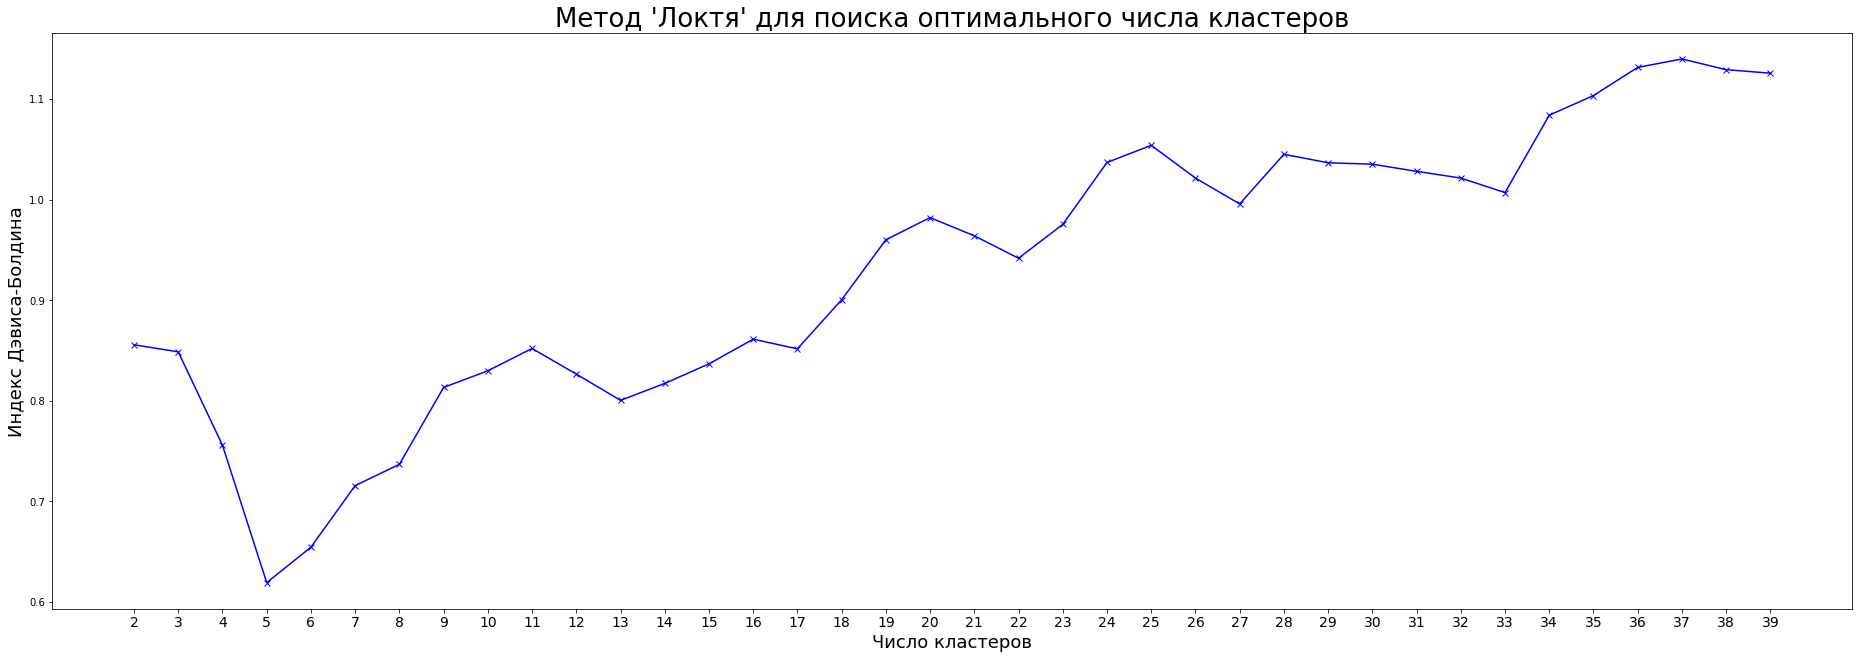

In [165]:
# Создание списка для сохранения значений индекса Дэвиса-Болдина
davies_bouldin_scores = []

# Запуск агломеративной кластеризации для различного числа кластеров
for k in range(2, 40):
    clustering = AgglomerativeClustering(n_clusters=k)
    clustering.fit(ss)
    davies_bouldin_scores.append(davies_bouldin_score(df_tsne, clustering.labels_))

# Построение графика зависимости значения функционала качества кластеризации от числа кластеров
fig = plt.figure(figsize=(25,8))
fig.add_axes([0,0,1,1])
plt.plot(range(2, 40), davies_bouldin_scores, marker='x', color='blue')
plt.xlabel("Число кластеров", fontsize=18)
plt.ylabel("Индекс Дэвиса-Болдина", fontsize=18)
plt.title("Метод 'Локтя' для поиска оптимального числа кластеров", fontsize = 26)
plt.xticks(range(2, 40), fontsize=14)
plt.show()

In [168]:
import plotly.graph_objects as go
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering
import numpy as np

clustering = AgglomerativeClustering(n_clusters=5).fit(ss)

fig = px.scatter_3d(x=ss[:, 0], y=ss[:, 1], z=ss[:, 2], color=clustering.labels_, color_continuous_scale='viridis')
fig.update_layout(scene=dict(xaxis_title='t-SNE 1 компонента',
                             yaxis_title='t-SNE 2 компонента',
                             zaxis_title='t-SNE 3 компонента',
                             xaxis=dict(backgroundcolor="rgb(200, 200, 230)"),
                             yaxis=dict(backgroundcolor="rgb(230, 200,230)"),
                             zaxis=dict(backgroundcolor="rgb(230, 230,200)")),
                  width=900, height=900,
                  title='Агломеративная кластеризация пациентов с ПКС',
                  legend=dict(title='Кластеры', font=dict(size=12)))
fig.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning:

G

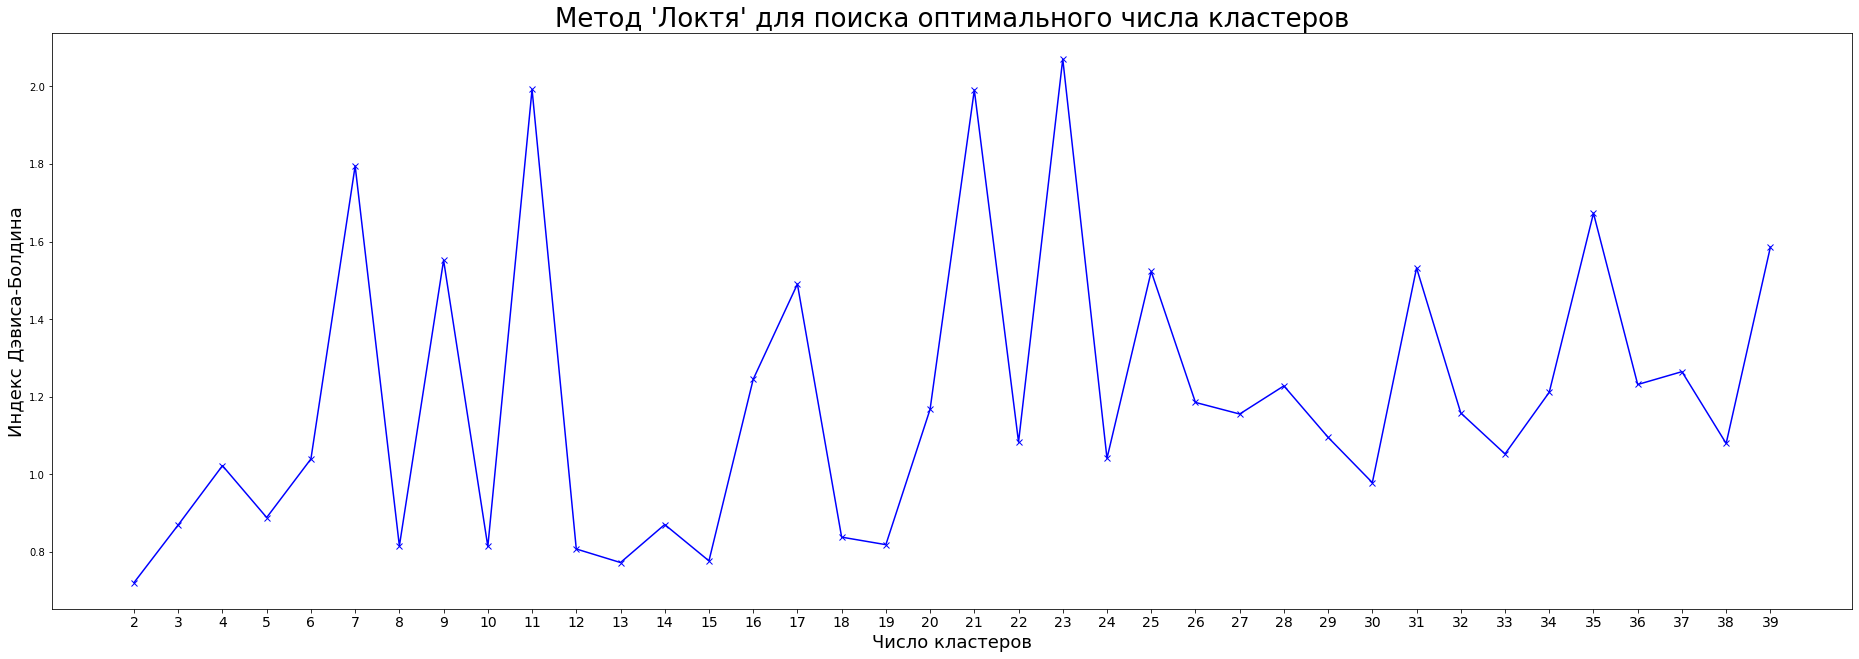

In [167]:
# Создание списка для сохранения значений индекса Дэвиса-Болдина
davies_bouldin_scores = []

# Запуск агломеративной кластеризации для различного числа кластеров
for k in range(2, 40):
    clustering = SpectralClustering(n_clusters=k, affinity='nearest_neighbors',
                           assign_labels='kmeans')
    clustering.fit(ss)
    davies_bouldin_scores.append(davies_bouldin_score(df_tsne, clustering.labels_))

# Построение графика зависимости значения функционала качества кластеризации от числа кластеров
fig = plt.figure(figsize=(25,8))
fig.add_axes([0,0,1,1])
plt.plot(range(2, 40), davies_bouldin_scores, marker='x', color='blue')
plt.xlabel("Число кластеров", fontsize=18)
plt.ylabel("Индекс Дэвиса-Болдина", fontsize=18)
plt.title("Метод 'Локтя' для поиска оптимального числа кластеров", fontsize = 26)
plt.xticks(range(2, 40), fontsize=14)
plt.show()

**Вывод:** При использовании спектральной кластеризации модель работает нестабильно. Оптимально использовать агломеративную кластеризацию с тремя главными компонентами.

In [169]:
df_unique['clusters'] = clustering.labels_
df_unique.head()

,Возраст пациента,Пол пациента,Длительность COVID-19,Число дней до 1 ПКС,Число дней до 2 ПКС,Число дней до 3 ПКС,Число дней до 4 ПКС,ПКС_1_I67.8,ПКС_1_I11.9,ПКС_1_J41.0,...,ПКС_4_J42,ПКС_4_I50.0,ПКС_4_I50.9,ПКС_4_J41.0,ПКС_4_I11.9,ПКС_4_I48.0,ПКС_4_J44.9,ПКС_4_I11.0,ПКС_4_J44.8,clusters
4070,52,1,43,132,136,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2806,78,1,27,55,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
7466,71,0,64,172,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
9774,68,0,53,174,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
6564,31,0,1,37,156,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
# Сохраняем датасет
df_unique.to_excel('df_clusters.xlsx')

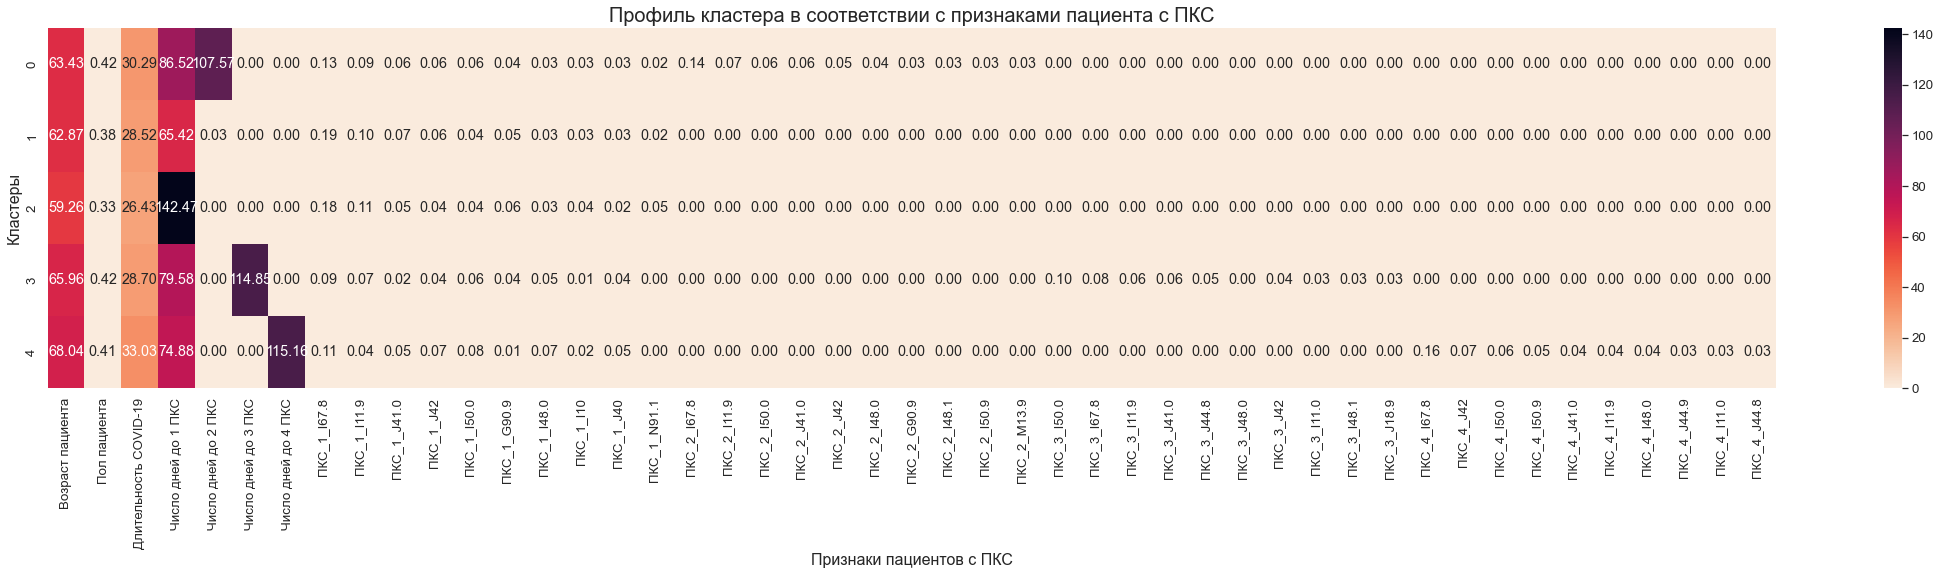

In [180]:
import seaborn as sns
import matplotlib.pyplot as plt

# выбор цветовой карты
cmap = sns.cm.rocket_r

fig = plt.figure(figsize=(30, 5))
ax = fig.add_axes([0,0,1,1])
# увеличение размера шрифта
sns.set(font_scale=1.2)

# создание тепловой карты
ax = sns.heatmap(df_unique.groupby('clusters')[list(df_unique.columns[:-1])].mean(), cmap=cmap, annot=True, fmt=".2f")

# добавление названия осей
ax.set_xlabel('Признаки пациентов с ПКС', fontsize=16)
ax.set_ylabel('Кластеры', fontsize=16)

# добавление заголовка графика
ax.set_title('Профиль кластера в соответствии с признаками пациента с ПКС', fontsize=20)

# показ графика
plt.show()


# Создаем модель классификации для определения кластера

In [6]:
# Делим датасет на тестовый и тренировочный, выделяем целевую переменную.
X = df_unique.drop('clusters', axis=1)
y = df_unique['clusters']
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
print('Размер тестовой выборки -', X_test.shape[0])

Размер тестовой выборки - 1335


In [7]:
# С помощью gridsearch ищем оптимальные параметры для случайного леса
from sklearn import ensemble
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

gridsearch_cv = model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5
)
gridsearch_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 15),
                         'n_estimators': [100, 200, 500]},
             scoring='accuracy')

In [8]:
# Выводим значения для наилучших параметров
gridsearch_cv.best_params_

{'criterion': 'entropy', 'max_depth': 14, 'n_estimators': 500}

In [14]:
# Обучаем случайный лес на наилучших параметрах
from sklearn import metrics
rft = ensemble.RandomForestClassifier(criterion='entropy', n_estimators=500, max_depth=14, random_state=42)
rft.fit(X_train, y_train)
y_pred_rft = rft.predict(X_test)
print('Значение метрики Accuracy на тестовых данных -', round(metrics.accuracy_score(y_test, y_pred_rft),3))

Значение метрики Accuracy на тестовых данных - 0.986


In [12]:
# С помощью gridsearch ищем оптимальные параметры для градиентного бустинга
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

gridsearch_cv = model_selection.GridSearchCV(
    estimator=ensemble.GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5
)
gridsearch_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': range(3, 7),
                         'n_estimators': [100, 200, 500]},
             scoring='accuracy')

In [13]:
# Выводим значения для наилучших параметров
gridsearch_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

In [15]:
# Обучаем градиентный бустинг на наилучших параметрах
gbc = ensemble.GradientBoostingClassifier(learning_rate=0.1, max_depth=6, n_estimators=200, random_state=42)
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
print('Значение метрики Accuracy на тестовых данных -', round(metrics.accuracy_score(y_test, y_pred_gbc),3))

Значение метрики Accuracy на тестовых данных - 0.997


# Сохраняем модель для вывода ее в продакшн

In [16]:
import pickle
# Производим сериализацию и записываем результат в файл формата pkl
with open('clustering.pkl', 'wb') as output:
    pickle.dump(gbc, output)